# Modelling Wave properties

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

wec_data = pd.read_excel('ARIN1 copy.xlsx')
wec_data.columns = ['time', 'wem'] #in sec and Nm, respectively
wec_data.head()

,time,wem
0,0.05,-0.241213
1,0.10,0.353760
2,0.15,0.538115
3,0.20,0.706059
4,0.25,0.629762


In [2]:
time = wec_data['time'].values
wem = wec_data['wem'].values

In [3]:
# This cell defines functions to estimate the amplitude and frequency of the wave excitation moment (WEM)
# using an Extended Kalman Filter (EKF), and then computes reference angular velocity, period inverse,
# power, and cumulative energy extracted from the WEM signal. It processes the input data (wem, time)
# and produces the variables amp_ekf, omega_ekf, theta_dot_ref, T_inv, power, and energy for model building.

import numpy as np

def ekf_amplitude_frequency(wem, Ts):

    #extended kalman filter 

    n = len(wem)
    A_ex = np.zeros(n)
    omega = np.zeros(n)
    
    psi, psi_star, w = wem[0], wem[0], 5.0
    P = np.eye(3) * 0.1
    Q = np.diag([0.2, 0.2, 0.001])
    R = 0.1
    
    for k in range(n):
        cos_wTs = np.cos(w * Ts)
        sin_wTs = np.sin(w * Ts)
        psi_pred = cos_wTs * psi + sin_wTs * psi_star
        psi_star_pred = -sin_wTs * psi + cos_wTs * psi_star
        w_pred = w
        x_pred = np.array([psi_pred, psi_star_pred, w_pred])
        
        F = np.array([
            [cos_wTs, sin_wTs, Ts * (-sin_wTs * psi + cos_wTs * psi_star)],
            [-sin_wTs, cos_wTs, Ts * (-cos_wTs * psi - sin_wTs * psi_star)],
            [0, 0, 1]
        ])
        
        P = F @ P @ F.T + Q
        
        y = wem[k]
        H = np.array([[1, 0, 0]])
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
        x_upd = x_pred + K.flatten() * (y - H @ x_pred)
        P = (np.eye(3) - K @ H) @ P
        
        psi, psi_star, w = x_upd
        A_ex[k] = np.sqrt(psi**2 + psi_star**2)
        omega[k] = w
    
    return A_ex, omega #rad/s


# Radiation damping function
def B_omega(omega):
    return 0.1 * omega  

def compute_reference_velocity(M_ex, A_ex, omega,
                                K_v0=1.8, theta_lim=0.4):
    """
    Computes reference angular velocity θ̇_ref based on WEM estimates.
    """
    A_ex_safe = np.where(A_ex < 1e-6, 1e-6, A_ex)
    B = B_omega(omega)

    T_inv_limit = (omega * theta_lim) / A_ex_safe
    T_inv_nominal = 1 / (2 * B + 2 * K_v0)
    T_inv = np.minimum(T_inv_limit, T_inv_nominal)

    return T_inv * M_ex

def compute_power_energy(theta_dot_ref, M_ex, Ts=0.05, mu_gen=0.7):
    """
    Compute power and cumulative extracted energy using reference velocity.
    """
    power = mu_gen * M_ex * theta_dot_ref
    energy = np.cumsum(power) * Ts
    return power, energy

def compute_T_inv(M_ex, A_ex, omega,
                        B_omega=0.5, K_v0=1.8, theta_lim=0.4):
    """
    Computes the inverse of the wave period T_inv.
    """
    return np.where(
        (omega * theta_lim / A_ex) > 1 / (2 * B_omega + 2 * K_v0),
        1 / (2 * B_omega + 2 * K_v0),
        (omega * theta_lim) / A_ex
    )

Ts = np.mean(np.diff(time))  #sampling time step

amp_ekf, omega_ekf = ekf_amplitude_frequency(wem, Ts)

theta_dot_ref = compute_reference_velocity(wem, amp_ekf, omega_ekf)

T_inv = compute_T_inv(wem, amp_ekf, omega_ekf)

power, energy = compute_power_energy(theta_dot_ref, wem, Ts)


In [4]:
# This section creates a DataFrame to store the processed data, 
# including time, wave excitation moment (wem), period inverse (T_inv), amplitude (amp_ekf), 
# frequency (omega_ekf), reference angular velocity (theta_dot_ref), power, and energy.

df = pd.DataFrame()
df['time'] = time
df['wem'] = wem
df['period'] = T_inv #period inverse
df['amplitude'] = amp_ekf
df['frequency'] = omega_ekf
df['ref_velocity'] = theta_dot_ref
df['power'] = power
df['energy'] = energy

df.head()

,time,wem,period,amplitude,frequency,ref_velocity,power,energy
0,0.05,-0.241213,0.217391,0.308118,4.999886,-0.052438,0.008854,0.000443
1,0.10,0.353760,0.217391,0.189047,4.999255,0.076907,0.019045,0.001395
2,0.15,0.538115,0.217391,0.450739,4.999543,0.116984,0.044066,0.003598
3,0.20,0.706059,0.217391,0.644100,4.999637,0.153494,0.075863,0.007391
4,0.25,0.629762,0.217391,0.645137,4.999634,0.136907,0.060353,0.010409


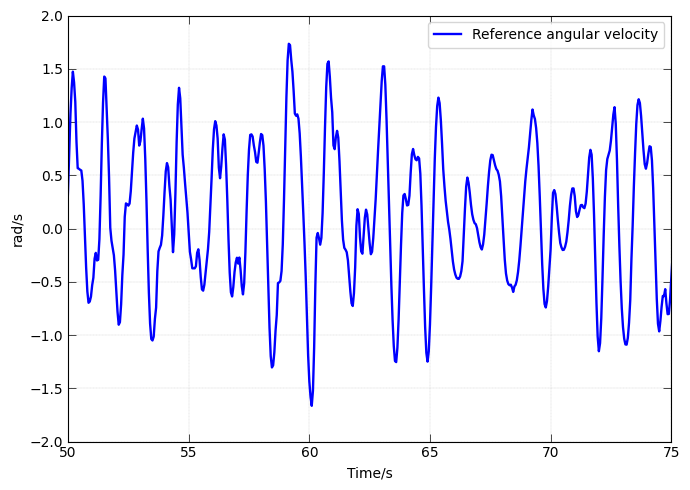

In [5]:
plt.figure(figsize=(7, 5))
plt.plot(time, theta_dot_ref, 
         label='Reference angular velocity', color='blue', linewidth=1.7)
# plt.plot(time, theta_dot, '--',
#          label='Float angular velocity', color='orange', linewidth=1.7)

plt.xlabel('Time/s')
plt.ylabel('rad/s')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)

# plt.axhline(0, color='black', lw=1, ls='--')
plt.xlim(left=50, right=75)
plt.ylim(bottom=-2, top=2)
# plt.title('Wave Excitation Moment (WEM) Over Time')
plt.tight_layout()
plt.savefig('ref_ekf.png', dpi=800, bbox_inches='tight')

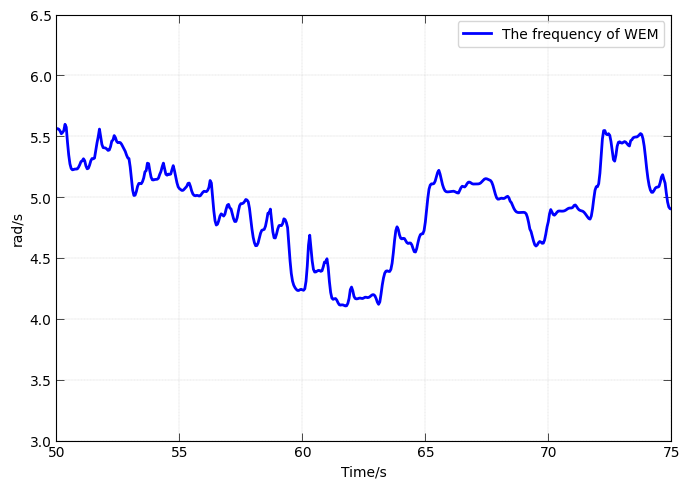

In [26]:
plt.figure(figsize=(7, 5))

plt.plot(time, omega_ekf, label='The frequency of WEM', color='blue', linewidth=2)
plt.xlabel('Time/s')
plt.ylabel('rad/s')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)


# plt.axhline(0, color='black', lw=1, ls='--')
plt.xlim(left=50, right=75)
plt.ylim(bottom=3, top=6.5)
# plt.title('Wave Excitation Moment (WEM) Over Time')
plt.tight_layout()
# plt.show()
plt.savefig('freq_ekf.png', dpi=800, bbox_inches='tight')

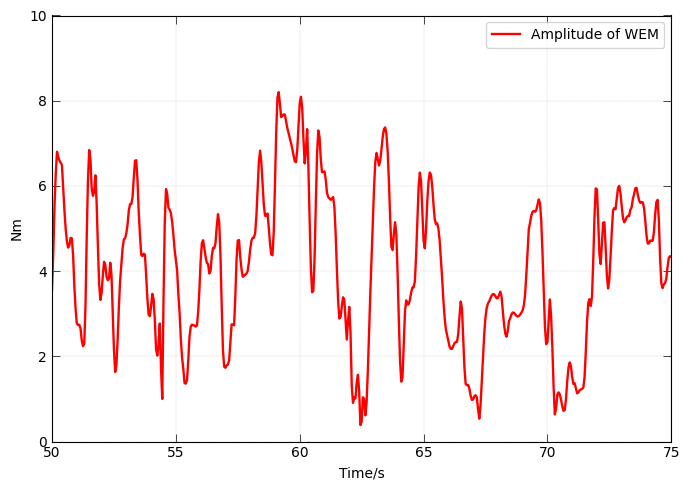

In [24]:
plt.figure(figsize=(7, 5))

plt.plot(time, amp_ekf, label='Amplitude of WEM', color='red', linewidth=1.7)
plt.xlabel('Time/s')
plt.ylabel('Nm')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)


# plt.axhline(0, color='black', lw=1, ls='--')
plt.xlim(left=50, right=75)
# plt.xlim(left=170, right=195)

plt.ylim(bottom=0, top=10)
# plt.title('Wave Excitation Moment (WEM) Over Time')
plt.tight_layout()
# plt.show()
plt.savefig('amp_ekf.png', dpi=800, bbox_inches='tight')

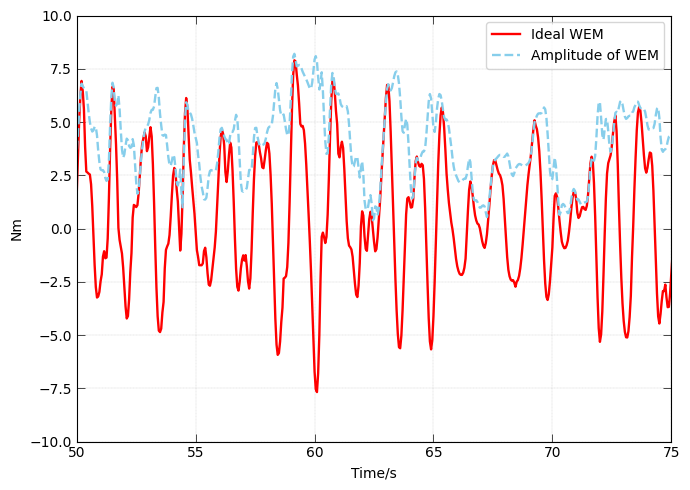

In [25]:
plt.figure(figsize=(7, 5))
plt.plot(time, wem, label='Ideal WEM', color='red', linewidth=1.7)
plt.plot(time, amp_ekf, '--', label='Amplitude of WEM', color='skyblue', linewidth=1.7)
plt.xlabel('Time/s')
plt.ylabel('Nm')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)


# plt.axhline(0, color='black', lw=1, ls='--')
plt.xlim(left=50, right=75)

plt.ylim(bottom=-10, top=10)
plt.tight_layout()
plt.show()

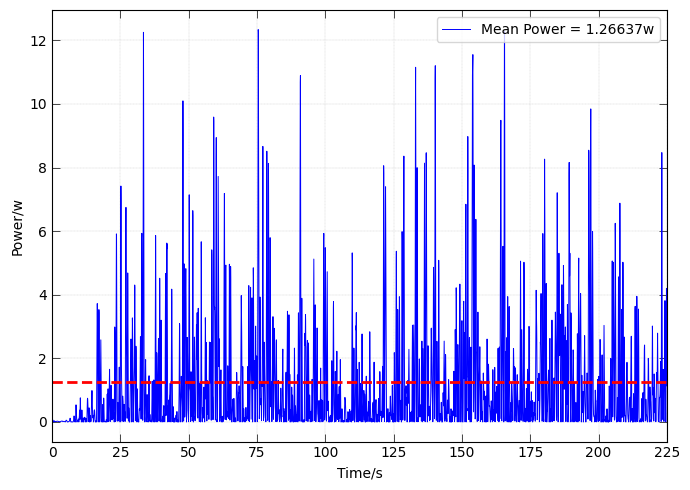

In [9]:
plt.figure(figsize=(7, 5))
plt.plot(time, power, color='blue', 
         label=f'Mean Power = {round(np.mean(power), 5)}w', linewidth=0.7)

plt.xlabel('Time/s')
plt.ylabel('Power/w')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)

plt.axhline(np.mean(power), color='red', lw=2, ls='--')
plt.xlim(left=0, right=max(time))
# plt.ylim(bottom=-2, top=2)
# plt.title('Wave Excitation Moment (WEM) Over Time')
plt.tight_layout()
plt.show()

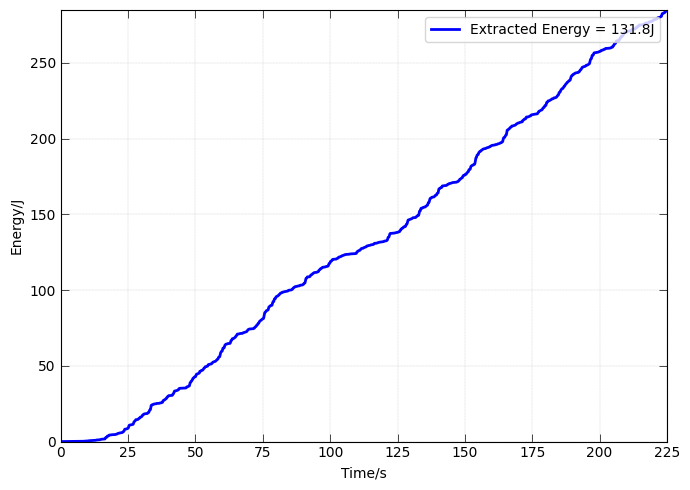

In [10]:
plt.figure(figsize=(7, 5))
plt.plot(time, energy, color='blue', 
         label=f'Extracted Energy = {round(np.mean(energy), 1)}J', linewidth=2)

plt.xlabel('Time/s')
plt.ylabel('Energy/J')
plt.grid(True, which='both', linestyle='--', linewidth=0.2)
plt.legend(loc='upper right', fontsize=10)

plt.tick_params(axis='both', which='both', direction='in', 
                length=6, width=0.5, top=True, right=True)

# plt.axhline(np.mean(power), color='red', lw=2, ls='--')
plt.xlim(left=0, right=max(time))
plt.ylim(bottom=0, top=max(energy))
# plt.title('Wave Excitation Moment (WEM) Over Time')
plt.tight_layout()
plt.show()

In [11]:
#save properties to file
df.to_excel('wec_results.xlsx', index=False)

In [1]:
import pandas as pd
df = pd.read_excel('wec_results.xlsx')

# Model Building

In [2]:
# This cell sets a random seed for reproducibility.
# It defines a function `set_seed` that makes sure all random operations in PyTorch, NumPy, and Python's random module produce the same results every time you run the notebook.

import torch
import numpy as np
import random
import os

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(42)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gpytorch
import cvxpy as cp
from gpytorch.kernels import SpectralMixtureKernel
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.lines import Line2D


In [4]:

wem = df['wem'].values
time = df['time'].values
theta_ref = df['ref_velocity'].values 
n_lags = 3
pred_horizon = 1

#### 1a. Gaussian Process (WEM)

In [6]:
# This cell prepares the data and builds a Gaussian Process Regression (GPR) model to predict the wave excitation moment (WEM) based on its recent history.
# It creates input features using the last 3 WEM values to predict the next WEM value, splits the data into training and testing sets,
# defines a GPR model with a flexible kernel, and provides a function to train the model on the training data.

def create_wem_features(wem, time, n_lags=3):
    X, y, t = [], [], []
    for i in range(n_lags, len(wem)):
        wem_window = wem[i - n_lags:i]
        X.append(wem_window)
        y.append(wem[i])
        t.append(time[i])

    return np.array(X), np.array(y), np.array(t)

class GPRModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # ARD Squared Exponential Kernel (RBF)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def train_gp_model(train_x, train_y, training_iter=100):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPRModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        if i % 10 == 0:
            print(f'Iter {i + 1}/{training_iter} - Loss: {loss.item():.3f}')
        optimizer.step()

    return model, likelihood

#create features and targets

X, y, t = create_wem_features(wem, time, n_lags=n_lags)

#train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
t_train, t_test = t[:split], t[split:]

#torch tensors
train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(y_train).float()
test_x = torch.from_numpy(X_test).float()
test_y = torch.from_numpy(y_test).float()


In [6]:
set_seed(42)
model, likelihood = train_gp_model(train_x, train_y, training_iter=100)

Iter 1/100 - Loss: 1.146
Iter 11/100 - Loss: 1.137
Iter 21/100 - Loss: 1.131
Iter 31/100 - Loss: 1.122
Iter 41/100 - Loss: 1.116
Iter 51/100 - Loss: 1.109
Iter 61/100 - Loss: 1.098
Iter 71/100 - Loss: 1.093
Iter 81/100 - Loss: 1.087
Iter 91/100 - Loss: 1.077


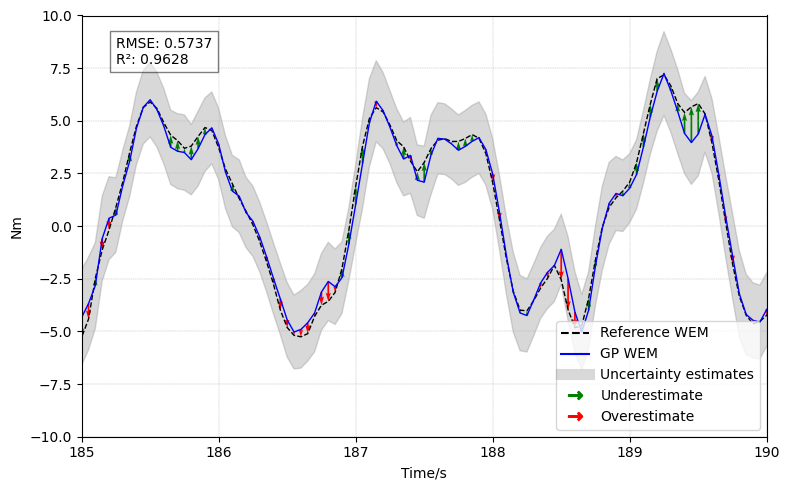

In [ ]:
def predict_gp(model, likelihood, test_x, test_y, t_test):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(test_x))
        mean = preds.mean
        lower, upper = preds.confidence_region()

    residuals = test_y.numpy() - mean.numpy()

    plt.figure(figsize=(8, 5))
    plt.plot(t_test, test_y.numpy(), '--', c='black', label='Reference WEM', linewidth=1.0)
    plt.plot(t_test, mean.numpy(), label='GP WEM', color='blue', linewidth=1.0)
    plt.fill_between(t_test, lower.numpy(), upper.numpy(), color='gray', 
                     alpha=0.3, label='Uncertainty estimates') #uncertainty region
    low = residuals > 0
    high = residuals <= 0

    plt.quiver(
        t_test[low], mean[low],
        [0]*np.sum(low), residuals[low],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='green', label='Underestimate'
    )
    plt.quiver(
        t_test[high], mean[high],
        [0]*np.sum(high), residuals[high],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='red', label='Overestimate'
    )
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.text(0.05, 0.95, f'RMSE: {np.sqrt(mean_squared_error(test_y.numpy(), mean.numpy())):.4f}\nR²: {r2_score(test_y.numpy(), mean.numpy()):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    plt.xlabel('Time/s')
    # plt.xlim(left=min(t_test), right=max(t_test))
    plt.xlim(185, 190)
    plt.ylim(bottom=-10, top=10)
    plt.ylabel('Nm')
    # plt.legend(loc='lower right', fontsize=10)
    legends = [
        Line2D([0], [0], linestyle='--', color='black', label='Reference WEM'),
        Line2D([0], [0], color='blue', label='GP WEM'),
        Line2D([0], [0], color='gray', lw=8, alpha=0.3, label='Uncertainty estimates'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='green', lw=0, markersize=10, label='Underestimate'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='red', lw=0, markersize=10, label='Overestimate'),
    ]
    plt.legend(handles=legends, loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()

predict_gp(model, likelihood, test_x, test_y, t_test)

#### 1b. Gaussian Process (Ref Velocity)

In [7]:
# def create_vel_features(wem, amp, freq, ref_vel, time, n_lags=3):
#     X, y, t = [], [], []
#     for i in range(n_lags, len(wem)):
#         features = np.hstack([
#             wem[i - n_lags:i],
#             amp[i - n_lags:i],
#             freq[i - n_lags:i],
#             # ref_vel[i - n_lags:i],
#         ])
#         X.append(features)
#         y.append(ref_vel[i])
#         t.append(time[i])
#     return np.array(X), np.array(y)

# This cell prepares the input features and target values for training and testing a model to predict the reference angular velocity (theta_ref) using past WEM values.
# It splits the data into training and test sets, and converts them into PyTorch tensors for model training.

def create_vel_features(wem, ref_velocity, time, n_lags=3):
    X, y, t = [], [], []
    for i in range(n_lags, len(wem)):
        wem_window = wem[i - n_lags:i]
        X.append(wem_window)
        y.append(ref_velocity[i])
        t.append(time[i])
    return np.array(X), np.array(y), np.array(t)


# wem = df.wem.values
# time = df.time.values
# amp_ekf = df.amplitude.values
# omega_ekf = df.frequency.values
# theta_ref = df.ref_velocity.values

# X, y = create_vel_features(wem, amp_ekf, omega_ekf, theta_ref, time, n_lags=3)
X, y, t = create_vel_features(wem, theta_ref, time, n_lags=3)

#train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
t_train, t_test = t[:split], t[split:]

#torch tensors
train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(y_train).float()
test_x = torch.from_numpy(X_test).float()
test_y = torch.from_numpy(y_test).float()

In [30]:
set_seed(42)
model2, likelihood2 = train_gp_model(train_x, train_y, training_iter=100)

Iter 1/100 - Loss: 0.824
Iter 11/100 - Loss: 0.819
Iter 21/100 - Loss: 0.816
Iter 31/100 - Loss: 0.810
Iter 41/100 - Loss: 0.807
Iter 51/100 - Loss: 0.804
Iter 61/100 - Loss: 0.796
Iter 71/100 - Loss: 0.794
Iter 81/100 - Loss: 0.791
Iter 91/100 - Loss: 0.783


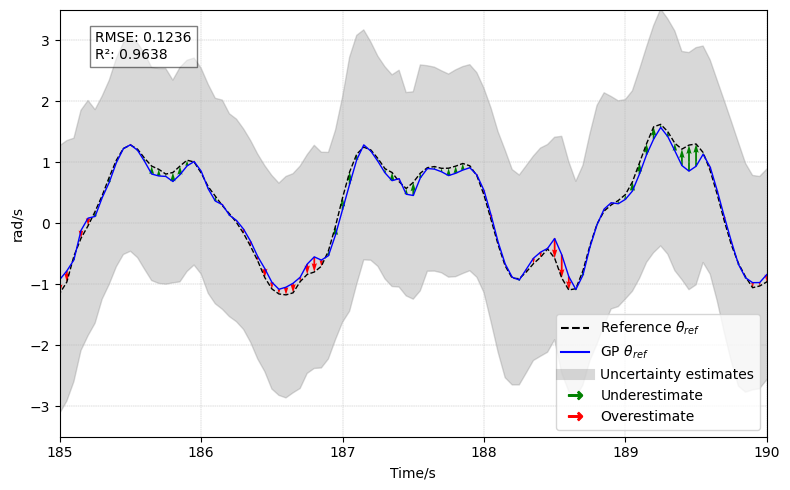

In [31]:

def predict_gp2(model, likelihood, test_x, test_y, t_test):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(test_x))
        mean = preds.mean
        lower, upper = preds.confidence_region()

    residuals = test_y.numpy() - mean.numpy()

    plt.figure(figsize=(8, 5))
    plt.plot(t_test, test_y.numpy(), '--', c='black', label='Reference $θ̇_{ref}$', linewidth=1.0)
    plt.plot(t_test, mean.numpy(), label='GP $θ̇_{ref}$', color='blue', linewidth=1.0)
    # plt.fill_between(t_test, lower.numpy(), upper.numpy(), color='gray', alpha=0.7, label='Uncertainty estimates') #uncertainty region
    plt.fill_between(t_test, lower.numpy(), upper.numpy(), color='gray', 
                     alpha=0.3, label='Uncertainty estimates') 
    low = residuals > 0
    high = residuals <= 0

    plt.quiver(
        t_test[low], mean[low],
        [0]*np.sum(low), residuals[low],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='green', label='Underestimate'
    )
    plt.quiver(
        t_test[high], mean[high],
        [0]*np.sum(high), residuals[high],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='red', label='Overestimate'
    )

    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.text(0.05, 0.95, f'RMSE: {np.sqrt(mean_squared_error(test_y.numpy(), mean.numpy())):.4f}\nR²: {r2_score(test_y.numpy(), mean.numpy()):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    plt.xlabel('Time/s')
    # plt.xlim(left=min(t_test), right=max(t_test))
    plt.xlim(185, 190)
    plt.ylim(-3.5, 3.5)
    plt.ylabel('rad/s')
    # plt.legend(loc='lower right', fontsize=10)
    legends = [
        Line2D([0], [0], linestyle='--', color='black', label='Reference $θ̇_{ref}$'),
        Line2D([0], [0], color='blue', label='GP $θ̇_{ref}$'),
        Line2D([0], [0], color='gray', lw=8, alpha=0.3, label='Uncertainty estimates'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='green', lw=0, markersize=10, label='Underestimate'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='red', lw=0, markersize=10, label='Overestimate'),
    ]
    plt.legend(handles=legends, loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()

predict_gp2(model2, likelihood2, test_x, test_y, t_test)

#### 1c. MPC Loop

In [60]:
# This cell sets up and runs a Model Predictive Control (MPC) simulation for a wave energy converter system.
# It defines the system model, prediction and optimization functions, and simulates the controller using GP-based forecasts.
# system Matrices (discrete-time WEC model)

Ad = np.array([
    [0.9248,  0.0470, -0.0031,  0.0003],
    [-2.9282, 0.8480, -0.1066,  0.0254],
    [-0.4740, 0.2578,  0.4037, -0.4609],
    [-0.0681, 0.0608,  0.2747,  0.8947]
])

Bd = np.array([
    [0.00081],
    [0.03171],
    [0.00513],
    [0.00074]
])

Bd_mex = np.array([
    [0.0],
    [0.0],
    [0.1],
    [0.0]
])

Cv = np.array([[0, 1, 0, 0]])  # output = angular velocity

# MPC Parameters
Np = 60
Qm = 0.5
Rm = 2e-4
u_max = 12.0

# Forecasting with GP

def forecast_gp(model, likelihood, input_hist, steps):
    """
    Forecast future values using GP model with autoregressive inputs.
    """
    model.eval()
    likelihood.eval()
    pred = []
    window = input_hist.copy()

    for _ in range(steps):
        x_in = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            y_pred = likelihood(model(x_in))
        next_val = y_pred.mean.item()
        pred.append(next_val)
        window = np.roll(window, -1)
        window[-1] = next_val

    return np.array(pred)

# Build MPC Prediction Matrices
def build_prediction_matrices(Ad, Bd, Bd_mex, Cv, N):
    n = Ad.shape[0]
    Sbv = np.zeros((N, N))
    Sav = np.zeros((N, n))
    Sbm = np.zeros((N, N))

    for i in range(N):
        Ai = np.linalg.matrix_power(Ad, i+1)
        Sav[i, :] = Cv @ Ai
        for j in range(i+1):
            A_ij = np.linalg.matrix_power(Ad, i-j)
            Sbv[i, j] = Cv @ A_ij @ Bd
            Sbm[i, j] = Cv @ A_ij @ Bd_mex

    return Sav, Sbv, Sbm

# -MPC Optimization
def solve_mpc(xk, mex_pred, vref_pred, Sav, Sbv, Sbm):
    u = cp.Variable(Np)
    V = Sav @ xk + Sbv @ u + Sbm @ mex_pred
    cost = cp.sum_squares(V - vref_pred) * Qm + cp.sum_squares(u) * Rm
    constraints = [cp.abs(u) <= u_max]

    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.OSQP)

    return u.value[0] if u.value is not None else 0.0

# MPC Simulation Loop
def run_mpc_simulation(x0, wem_series, model_mex, likelihood_mex,
                       model_vref, likelihood_vref,
                       steps=100, wem_lag=12, vref_lag=12):

    x = x0.copy()
    Sav, Sbv, Sbm = build_prediction_matrices(Ad, Bd, Bd_mex, Cv, Np)

    x_log = [x.copy()]
    u_log = []
    v_log = []
    vref_log = []

    for k in range(steps):
        # WEM input history for both models
        wem_hist = wem_series[k : k + wem_lag]
        wem_hist_vref = wem_series[k : k + vref_lag]  # For second GP

        if len(wem_hist) < wem_lag or len(wem_hist_vref) < vref_lag:
            break

        # Predict future mex and ref_velocity using WEM-only inputs
        mex_pred = forecast_gp(model_mex, likelihood_mex, wem_hist, Np)
        vref_pred = forecast_gp(model_vref, likelihood_vref, wem_hist_vref, Np)

        # Solve MPC
        u = solve_mpc(x, mex_pred, vref_pred, Sav, Sbv, Sbm)

        # Update state
        x = Ad @ x + Bd.flatten() * u + Bd_mex.flatten() * wem_series[wem_lag + k]

        # Log
        x_log.append(x.copy())
        u_log.append(u)
        v_log.append((Cv @ x).item())
        vref_log.append(vref_pred[0])

    return np.array(x_log), np.array(u_log), np.array(v_log), np.array(vref_log)

x0 = np.zeros(4)
x_log, u_log, v_log, vref_log = run_mpc_simulation(
    x0, wem, model, likelihood, model2, likelihood2,
    steps=1000, wem_lag=3, vref_lag=3
)

/tmp/ipykernel_13827/4103958131.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sbv[i, j] = Cv @ A_ij @ Bd
/tmp/ipykernel_13827/4103958131.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sbm[i, j] = Cv @ A_ij @ Bd_mex


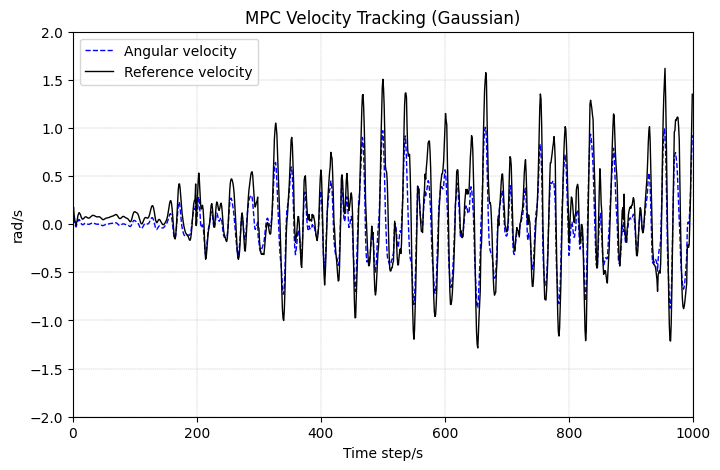

In [61]:
plt.figure(figsize=(8, 5))
plt.plot(v_log, '--', c='blue', label='Angular velocity', linewidth=1.0)
plt.plot(vref_log, c='black', label='Reference velocity', linewidth=1.0)
plt.grid(True, which='both', linestyle='--', linewidth=0.3)
plt.xlabel('Time step/s')
plt.ylabel('rad/s')
plt.xlim(left=0, right=len(v_log))
plt.ylim(bottom=-2, top=2)
plt.legend()
plt.title("MPC Velocity Tracking (Gaussian)")
plt.show()

#### 2a. LSTM and Seq2Seq (WEM modelling)

In [ ]:
# Builds Standard LSTM and Seq2Seq LSTM model

class LSTMRegression(nn.Module):
    '''many2one'''
    def __init__(self, input_size=1, hidden_size=16, num_layers=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

class Seq2SeqLSTM(nn.Module):
    '''many2many'''
    def __init__(self, input_dim=1, hidden_dim=16, output_len=1,
                  num_layers=1, dropout=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_len = output_len

        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(1, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)

        # Encode input sequence
        _, (hidden, cell) = self.encoder(x)

        # First decoder input = last input timestep
        decoder_input = x[:, -1:, :]  # shape: (B, 1, 1)

        outputs = []
        for _ in range(self.output_len):
            out, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            out = self.dropout(out)
            pred = self.fc(out)  # shape: (B, 1, 1)
            outputs.append(pred)
            decoder_input = pred  # feedback

        outputs = torch.cat(outputs, dim=1)  # shape: (B, output_len, 1)
        return outputs.squeeze(-1)  # shape: (B, output_len)


def preprocess_wem(wem, time, n_lags=3, test_ratio=0.2):
    X, y, t = create_wem_features(wem, time, n_lags=n_lags)

    X_scaled = X.reshape(-1, n_lags, 1) 
    y_scaled = y

    # Split
    split_idx = int(len(X_scaled) * (1 - test_ratio))
    X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]
    t_train, t_test = t[:split_idx], t[split_idx:]

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
        t_train, t_test#, scaler_x, scaler_y
    )

def train_lstm_model(X_train, y_train, type='seq2seq', n_epochs=100, lr=1e-3, batch_size=32):
    if type == 'seq2seq':
        model = Seq2SeqLSTM(input_dim=X_train.shape[2], dropout=0.3)
    elif type == 'standard':
        model = LSTMRegression(input_size=X_train.shape[2], dropout=0.3)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=1e-5)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=batch_size, shuffle=True
    )

    for epoch in range(n_epochs):
        model.train()
        losses = []
        for xb, yb in train_loader:
            pred = model(xb).squeeze(-1)  
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        # if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {np.mean(losses):.4f}")

    return model


X_train, y_train, X_test, y_test, t_train, t_test = preprocess_wem(wem, time, n_lags=n_lags)


In [9]:
set_seed(42)
model3 = train_lstm_model(X_train, y_train, type='seq2seq', n_epochs=10)
model4 = train_lstm_model(X_train, y_train, type='standard', n_epochs=10)

Epoch 1/10 - Loss: 6.1085
Epoch 2/10 - Loss: 2.8068
Epoch 3/10 - Loss: 1.3492
Epoch 4/10 - Loss: 0.6972
Epoch 5/10 - Loss: 0.5533
Epoch 6/10 - Loss: 0.4486
Epoch 7/10 - Loss: 0.4139
Epoch 8/10 - Loss: 0.4112
Epoch 9/10 - Loss: 0.3826
Epoch 10/10 - Loss: 0.3586
Epoch 1/10 - Loss: 6.1552
Epoch 2/10 - Loss: 3.4309
Epoch 3/10 - Loss: 1.9066
Epoch 4/10 - Loss: 1.1091
Epoch 5/10 - Loss: 0.8170
Epoch 6/10 - Loss: 0.6416
Epoch 7/10 - Loss: 0.6020
Epoch 8/10 - Loss: 0.4938
Epoch 9/10 - Loss: 0.4809
Epoch 10/10 - Loss: 0.4514


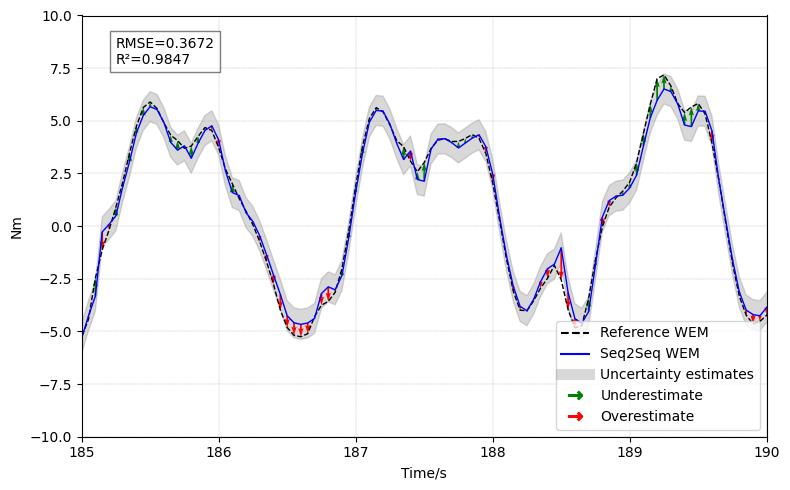

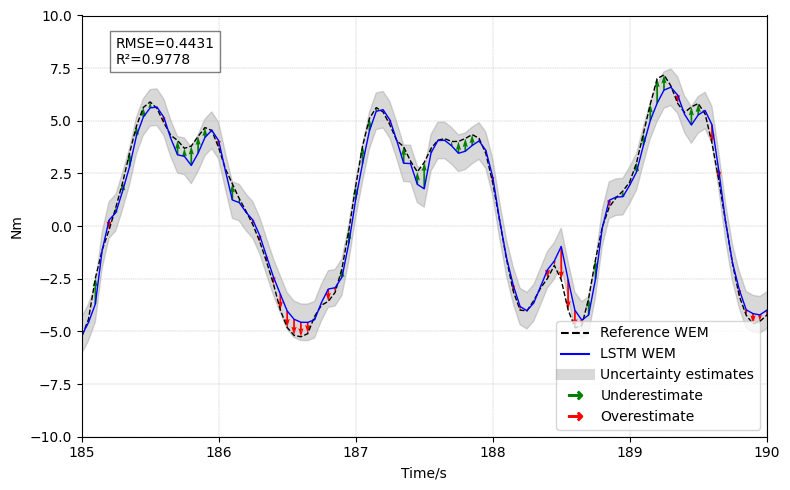

In [10]:
def plot_lstm1(model, X_test, y_test, t_test, type='seq2seq'):
    model.eval()
    with torch.no_grad():
        pred = model(X_test).squeeze(-1).numpy()
        true = y_test.numpy()

    # Compute residual standard deviation
    residuals = true - pred
    std = np.std(residuals)

    # 95% confidence bounds
    lower = pred - 1.96 * std
    upper = pred + 1.96 * std

    # Plot
    plt.figure(figsize=(8, 5))
    
    plt.plot(t_test, true, '--', c='black', label='Reference WEM', linewidth=1.0)
    plt.plot(t_test, pred, label='GP WEM', color='blue', linewidth=1.0)
    plt.fill_between(t_test, lower, upper, color='gray', 
                     alpha=0.3, label='Uncertainty estimates') #uncertainty region
    low = residuals > 0
    high = residuals <= 0

    plt.quiver(
        t_test[low], pred[low],
        [0]*np.sum(low), residuals[low],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='green', label='Underestimate'
    )
    plt.quiver(
        t_test[high], pred[high],
        [0]*np.sum(high), residuals[high],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='red', label='Overestimate'
    )
    
    
    plt.text(0.05, 0.95, 
             f'RMSE={np.sqrt(mean_squared_error(true, pred)):.4f}\nR²={r2_score(true, pred):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
             bbox=dict(facecolor='white', alpha=0.5))
    plt.xlabel('Time/s')
    # plt.xlim(left=min(t_test), right=max(t_test))
    plt.xlim(185, 190)
    plt.ylim(bottom=-10, top=10)
    plt.ylabel('Nm')
    # plt.legend(loc='lower right', fontsize=10)
    legends = [
        Line2D([0], [0], linestyle='--', color='black', label='Reference WEM'),
        Line2D([0], [0], color='blue', label='LSTM WEM' if type=='standard' else 'Seq2Seq WEM'),
        Line2D([0], [0], color='gray', lw=8, alpha=0.3, label='Uncertainty estimates'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='green', lw=0, markersize=10, label='Underestimate'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='red', lw=0, markersize=10, label='Overestimate'),
    ]
    plt.legend(handles=legends, loc='lower right', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()
plot_lstm1(model3, X_test, y_test, t_test, type='seq2seq')
plot_lstm1(model4, X_test, y_test, t_test, type='standard')

#### 2b. LSTM (Reference Velocity)

In [11]:
def preprocess_vel(wem, theta_ref, time, n_lags=3, test_ratio=0.2):
    X, y, t = create_vel_features(wem, theta_ref, time, n_lags=n_lags)

    X_scaled = X.reshape(-1, n_lags, 1) 
    y_scaled = y

    # Split
    split_idx = int(len(X_scaled) * (1 - test_ratio))
    X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]
    t_train, t_test = t[:split_idx], t[split_idx:]

    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_test, dtype=torch.float32),
        t_train, t_test#, scaler_x, scaler_y
    )

X_train2, y_train2, X_test2, y_test2, t_train2, t_test2 = preprocess_vel(wem, theta_ref, time, n_lags=n_lags)

In [12]:
set_seed(42)
model5 = train_lstm_model(X_train2, y_train2, type='seq2seq', n_epochs=10)
model6 = train_lstm_model(X_train2, y_train2, type='standard', n_epochs=10)

Epoch 1/10 - Loss: 0.1655
Epoch 2/10 - Loss: 0.0681
Epoch 3/10 - Loss: 0.0459
Epoch 4/10 - Loss: 0.0257
Epoch 5/10 - Loss: 0.0215
Epoch 6/10 - Loss: 0.0183
Epoch 7/10 - Loss: 0.0169
Epoch 8/10 - Loss: 0.0175
Epoch 9/10 - Loss: 0.0172
Epoch 10/10 - Loss: 0.0154
Epoch 1/10 - Loss: 0.1613
Epoch 2/10 - Loss: 0.0806
Epoch 3/10 - Loss: 0.0440
Epoch 4/10 - Loss: 0.0292
Epoch 5/10 - Loss: 0.0244
Epoch 6/10 - Loss: 0.0203
Epoch 7/10 - Loss: 0.0204
Epoch 8/10 - Loss: 0.0176
Epoch 9/10 - Loss: 0.0174
Epoch 10/10 - Loss: 0.0162


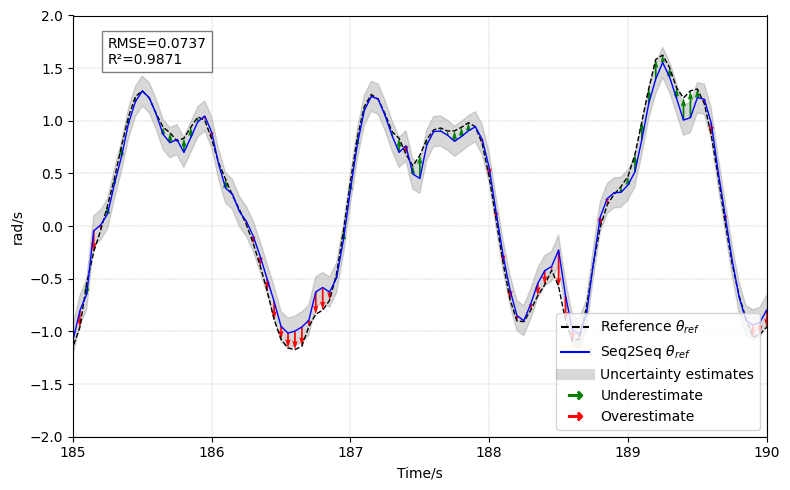

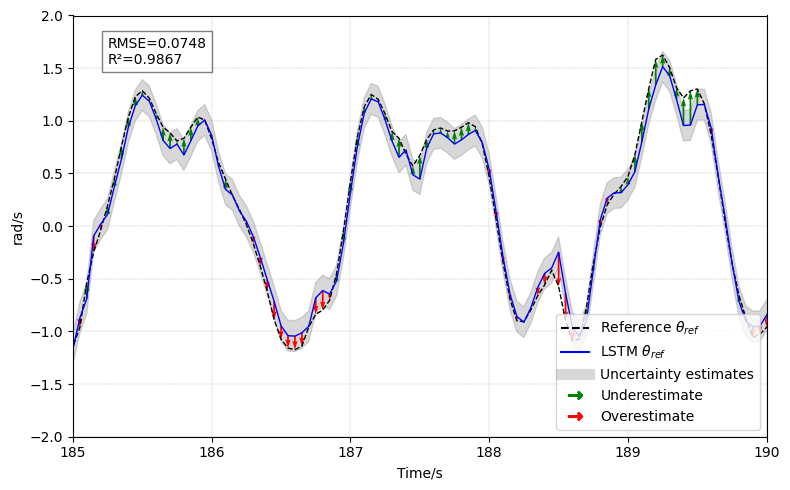

In [13]:
def plot_lstm2(model, X_test, y_test, t_test, type='seq2seq'):
    model.eval()
    with torch.no_grad():
        pred = model(X_test).squeeze(-1).numpy()
        true = y_test.numpy()

    # Compute residual standard deviation
    residuals = true - pred
    std = np.std(residuals)

    # 95% confidence bounds
    lower = pred - 1.96 * std
    upper = pred + 1.96 * std

    # Plot
    plt.figure(figsize=(8, 5))
    
    plt.plot(t_test, true, '--', c='black', label='Reference $θ̇_{ref}$', linewidth=1.0)
    plt.plot(t_test, pred, label='LSTM $θ̇_{ref}$' if type=='standard' else 'Seq2Seq $θ̇_{ref}$', color='blue', linewidth=1.0)
    plt.fill_between(t_test, lower, upper, color='gray', 
                     alpha=0.3, label='Uncertainty estimates') #uncertainty region
    low = residuals > 0
    high = residuals <= 0

    plt.quiver(
        t_test[low], pred[low],
        [0]*np.sum(low), residuals[low],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='green', label='Underestimate'
    )
    plt.quiver(
        t_test[high], pred[high],
        [0]*np.sum(high), residuals[high],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='red', label='Overestimate'
    )
    
    
    plt.text(0.05, 0.95, 
             f'RMSE={np.sqrt(mean_squared_error(true, pred)):.4f}\nR²={r2_score(true, pred):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
             bbox=dict(facecolor='white', alpha=0.5))
    plt.xlabel('Time/s')
    # plt.xlim(left=min(t_test), right=max(t_test))
    plt.xlim(185, 190)
    plt.ylim(bottom=-2, top=2)
    plt.ylabel('rad/s')
    # plt.legend(loc='lower right', fontsize=10)
    legends = [
        Line2D([0], [0], linestyle='--', color='black', label='Reference $θ̇_{ref}$'),
        Line2D([0], [0], color='blue', label='LSTM $θ̇_{ref}$' if type=='standard' else 'Seq2Seq $θ̇_{ref}$'),
        Line2D([0], [0], color='gray', lw=8, alpha=0.3, label='Uncertainty estimates'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='green', lw=0, markersize=10, label='Underestimate'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='red', lw=0, markersize=10, label='Overestimate'),
    ]
    plt.legend(handles=legends, loc='lower right', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()
plot_lstm2(model5, X_test2, y_test2, t_test2, type='seq2seq')
plot_lstm2(model6, X_test2, y_test2, t_test2, type='standard')

#### 3a. Neural Network (WEM)

In [14]:
class NeuralRegression(nn.Module):
    def __init__(self, input_size):
        super(NeuralRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

def train_nn(X_train, y_train, n_epochs=100, lr=1e-3, batch_size=32):
    model = NeuralRegression(input_size=X_train.shape[1])
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=1e-5)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=batch_size, shuffle=True
    )

    for epoch in range(n_epochs):
        model.train()
        losses = []
        for xb, yb in train_loader:
            pred = model(xb).squeeze(-1)  
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        # if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {np.mean(losses):.4f}")

    return model

X_train3, y_train3, X_test3, y_test3, t_train3, t_test3 = preprocess_wem(wem, time, n_lags=n_lags)
X_train3 = X_train3.view(X_train3.size(0), -1)  # shape: (batch_size, n_lags)
y_train3 = y_train3.view(-1)                    # shape: (batch_size,)
X_test3 = X_test3.view(X_test3.size(0), -1)
y_test3 = y_test3.view(-1)


In [15]:
set_seed(42)
model7 = train_nn(X_train3, y_train3, n_epochs=10)

Epoch 1/10 - Loss: 4.7241
Epoch 2/10 - Loss: 0.6872
Epoch 3/10 - Loss: 0.1961
Epoch 4/10 - Loss: 0.1692
Epoch 5/10 - Loss: 0.1532
Epoch 6/10 - Loss: 0.1389
Epoch 7/10 - Loss: 0.1238
Epoch 8/10 - Loss: 0.1148
Epoch 9/10 - Loss: 0.1056
Epoch 10/10 - Loss: 0.0996


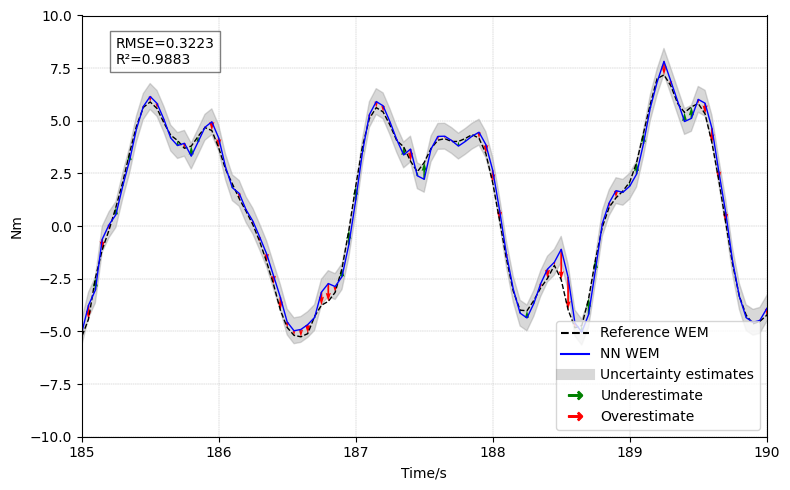

In [16]:
def plot_nn1(model, X_test, y_test, t_test):
    model.eval()
    with torch.no_grad():
        pred = model(X_test).squeeze(-1).numpy()
        true = y_test.numpy()

    # Compute residual standard deviation
    residuals = true - pred
    std = np.std(residuals)

    # 95% confidence bounds
    lower = pred - 1.96 * std
    upper = pred + 1.96 * std

    # Plot
    plt.figure(figsize=(8, 5))
    
    plt.plot(t_test, true, '--', c='black', label='Reference WEM', linewidth=1.0)
    plt.plot(t_test, pred, label='NN WEM', color='blue', linewidth=1.0)
    plt.fill_between(t_test, lower, upper, color='gray', 
                     alpha=0.3, label='Uncertainty estimates') #uncertainty region
    low = residuals > 0
    high = residuals <= 0

    plt.quiver(
        t_test[low], pred[low],
        [0]*np.sum(low), residuals[low],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='green', label='Underestimate'
    )
    plt.quiver(
        t_test[high], pred[high],
        [0]*np.sum(high), residuals[high],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='red', label='Overestimate'
    )
    
    
    plt.text(0.05, 0.95, 
             f'RMSE={np.sqrt(mean_squared_error(true, pred)):.4f}\nR²={r2_score(true, pred):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
             bbox=dict(facecolor='white', alpha=0.5))
    plt.xlabel('Time/s')
    # plt.xlim(left=min(t_test), right=max(t_test))
    plt.xlim(185, 190)
    plt.ylim(bottom=-10, top=10)
    plt.ylabel('Nm')
    # plt.legend(loc='lower right', fontsize=10)
    legends = [
        Line2D([0], [0], linestyle='--', color='black', label='Reference WEM'),
        Line2D([0], [0], color='blue', label='NN WEM'),
        Line2D([0], [0], color='gray', lw=8, alpha=0.3, label='Uncertainty estimates'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='green', lw=0, markersize=10, label='Underestimate'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='red', lw=0, markersize=10, label='Overestimate'),
    ]
    plt.legend(handles=legends, loc='lower right', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()
plot_nn1(model7, X_test3, y_test3, t_test3)

#### 3b. Neural Network (Reference Velocity Modelling)

In [17]:

X_train4, y_train4, X_test4, y_test4, t_train4, t_test4 = preprocess_vel(wem, theta_ref, time, n_lags=n_lags)
X_train4 = X_train4.view(X_train4.size(0), -1)  # shape: (batch_size, n_lags)
y_train4 = y_train4.view(-1)                    # shape: (batch_size,)
X_test4 = X_test4.view(X_test4.size(0), -1)
y_test4 = y_test4.view(-1)

In [18]:
set_seed(42)
model8 = train_nn(X_train4, y_train4, n_epochs=10)

Epoch 1/10 - Loss: 0.1563
Epoch 2/10 - Loss: 0.0134
Epoch 3/10 - Loss: 0.0089
Epoch 4/10 - Loss: 0.0078
Epoch 5/10 - Loss: 0.0069
Epoch 6/10 - Loss: 0.0062
Epoch 7/10 - Loss: 0.0055
Epoch 8/10 - Loss: 0.0052
Epoch 9/10 - Loss: 0.0049
Epoch 10/10 - Loss: 0.0049


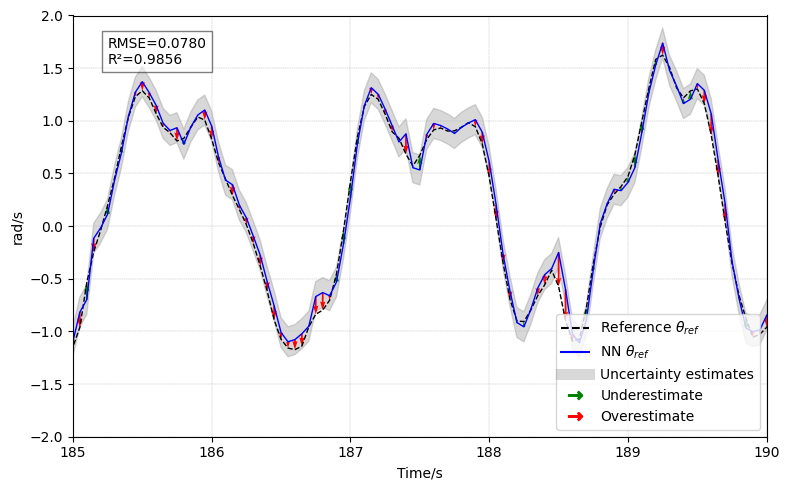

In [19]:
def plot_nn2(model, X_test, y_test, t_test):
    model.eval()
    with torch.no_grad():
        pred = model(X_test).squeeze(-1).numpy()
        true = y_test.numpy()

    # Compute residual standard deviation
    residuals = true - pred
    std = np.std(residuals)

    # 95% confidence bounds
    lower = pred - 1.96 * std
    upper = pred + 1.96 * std

    # Plot
    plt.figure(figsize=(8, 5))
    
    plt.plot(t_test, true, '--', c='black', label='Reference $θ̇_{ref}$', linewidth=1.0)
    plt.plot(t_test, pred, label='NN $θ̇_{ref}$', color='blue', linewidth=1.0)
    plt.fill_between(t_test, lower, upper, color='gray', 
                     alpha=0.3, label='Uncertainty estimates') #uncertainty region
    low = residuals > 0
    high = residuals <= 0

    plt.quiver(
        t_test[low], pred[low],
        [0]*np.sum(low), residuals[low],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='green', label='Underestimate'
    )
    plt.quiver(
        t_test[high], pred[high],
        [0]*np.sum(high), residuals[high],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='red', label='Overestimate'
    )
    
    
    plt.text(0.05, 0.95, 
             f'RMSE={np.sqrt(mean_squared_error(true, pred)):.4f}\nR²={r2_score(true, pred):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
             bbox=dict(facecolor='white', alpha=0.5))
    plt.xlabel('Time/s')
    # plt.xlim(left=min(t_test), right=max(t_test))
    plt.xlim(185, 190)
    plt.ylim(bottom=-2, top=2)
    plt.ylabel('rad/s')
    # plt.legend(loc='lower right', fontsize=10)
    legends = [
        Line2D([0], [0], linestyle='--', color='black', label='Reference $θ̇_{ref}$'),
        Line2D([0], [0], color='blue', label='NN $θ̇_{ref}$'),
        Line2D([0], [0], color='gray', lw=8, alpha=0.3, label='Uncertainty estimates'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='green', lw=0, markersize=10, label='Underestimate'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='red', lw=0, markersize=10, label='Overestimate'),
    ]
    plt.legend(handles=legends, loc='lower right', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()
plot_nn2(model8, X_test4, y_test4, t_test4)

#### 4a. GRU (WEM modelling)

In [20]:
class GRURegression(nn.Module):
    def __init__(self, input_size, hidden_size=16, num_layers=1, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

        # Feedforward tail
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, x):
        gru_out, _ = self.gru(x)                  # (B, T, H)
        last_timestep = gru_out[:, -1, :]         # (B, H)
        x = self.norm(last_timestep)
        x = self.dropout(x)
        return self.head(x).squeeze()

def train_gru(X_train, y_train, n_epochs=100, lr=1e-3, batch_size=32):
    model = GRURegression(input_size=X_train.shape[-1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=batch_size, shuffle=True
    )

    for epoch in range(n_epochs):
        model.train()
        losses = []
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {np.mean(losses):.4f}")

    return model

X_train5, y_train5, X_test5, y_test5, t_train5, t_test5 = preprocess_wem(wem, time, n_lags=n_lags)


In [21]:
set_seed(42)
model9 = train_gru(X_train5, y_train5, n_epochs=10)

/home/joshua-atolagbe/Documents/Projects/WEC/wecvenv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/10, Loss: 5.1662
Epoch 2/10, Loss: 2.0223
Epoch 3/10, Loss: 0.9298
Epoch 4/10, Loss: 0.6068
Epoch 5/10, Loss: 0.5225
Epoch 6/10, Loss: 0.4611
Epoch 7/10, Loss: 0.4424
Epoch 8/10, Loss: 0.4318
Epoch 9/10, Loss: 0.4291
Epoch 10/10, Loss: 0.3783


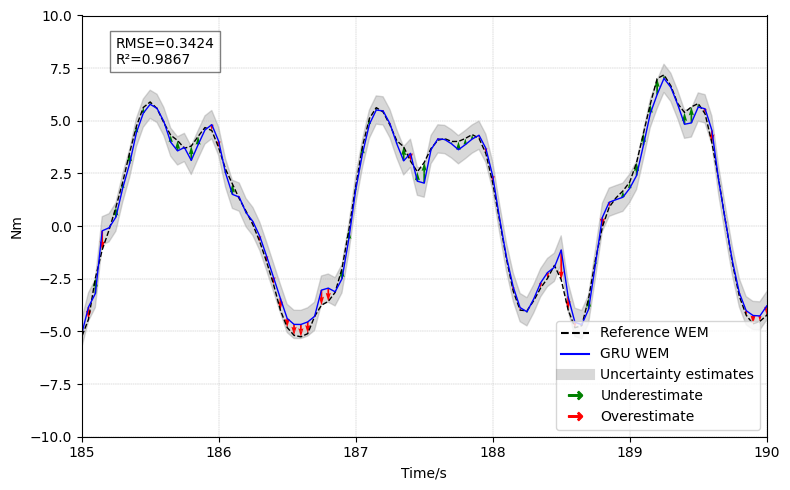

In [22]:
def plot_gru1(model, X_test, y_test, t_test):
    model.eval()
    with torch.no_grad():
        pred = model(X_test).squeeze(-1).numpy()
        true = y_test.numpy()

    # Compute residual standard deviation
    residuals = true - pred
    std = np.std(residuals)

    # 95% confidence bounds
    lower = pred - 1.96 * std
    upper = pred + 1.96 * std

    # Plot
    plt.figure(figsize=(8, 5))
    
    plt.plot(t_test, true, '--', c='black', label='Reference WEM', linewidth=1.0)
    plt.plot(t_test, pred, label='GRU WEM', color='blue', linewidth=1.0)
    plt.fill_between(t_test, lower, upper, color='gray', 
                     alpha=0.3, label='Uncertainty estimates') #uncertainty region
    low = residuals > 0
    high = residuals <= 0

    plt.quiver(
        t_test[low], pred[low],
        [0]*np.sum(low), residuals[low],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='green', label='Underestimate'
    )
    plt.quiver(
        t_test[high], pred[high],
        [0]*np.sum(high), residuals[high],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='red', label='Overestimate'
    )
    
    
    plt.text(0.05, 0.95, 
             f'RMSE={np.sqrt(mean_squared_error(true, pred)):.4f}\nR²={r2_score(true, pred):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
             bbox=dict(facecolor='white', alpha=0.5))
    plt.xlabel('Time/s')
    # plt.xlim(left=min(t_test), right=max(t_test))
    plt.xlim(185, 190)
    plt.ylim(bottom=-10, top=10)
    plt.ylabel('Nm')
    # plt.legend(loc='lower right', fontsize=10)
    legends = [
        Line2D([0], [0], linestyle='--', color='black', label='Reference WEM'),
        Line2D([0], [0], color='blue', label='GRU WEM'),
        Line2D([0], [0], color='gray', lw=8, alpha=0.3, label='Uncertainty estimates'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='green', lw=0, markersize=10, label='Underestimate'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='red', lw=0, markersize=10, label='Overestimate'),
    ]
    plt.legend(handles=legends, loc='lower right', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()
    
plot_gru1(model9, X_test5, y_test5, t_test5)

#### 4b. GRU (Reference Velocity)

In [23]:
X_train6, y_train6, X_test6, y_test6, t_train6, t_test6 = preprocess_vel(wem, theta_ref, time, n_lags=n_lags)

In [24]:
set_seed(42)
model10 = train_gru(X_train6, y_train6, n_epochs=10)

/home/joshua-atolagbe/Documents/Projects/WEC/wecvenv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/10, Loss: 0.1841
Epoch 2/10, Loss: 0.0677
Epoch 3/10, Loss: 0.0398
Epoch 4/10, Loss: 0.0316
Epoch 5/10, Loss: 0.0288
Epoch 6/10, Loss: 0.0250
Epoch 7/10, Loss: 0.0235
Epoch 8/10, Loss: 0.0215
Epoch 9/10, Loss: 0.0203
Epoch 10/10, Loss: 0.0180


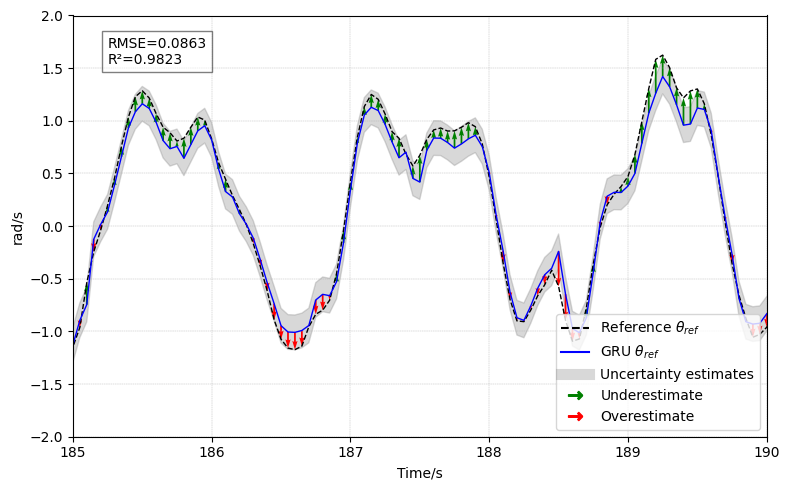

In [25]:
def plot_gru2(model, X_test, y_test, t_test):
    model.eval()
    with torch.no_grad():
        pred = model(X_test).squeeze(-1).numpy()
        true = y_test.numpy()

    # Compute residual standard deviation
    residuals = true - pred
    std = np.std(residuals)

    # 95% confidence bounds
    lower = pred - 1.96 * std
    upper = pred + 1.96 * std

    # Plot
    plt.figure(figsize=(8, 5))
    
    plt.plot(t_test, true, '--', c='black', label='Reference $θ̇_{ref}$', linewidth=1.0)
    plt.plot(t_test, pred, label='GRU $θ̇_{ref}$', color='blue', linewidth=1.0)
    plt.fill_between(t_test, lower, upper, color='gray', 
                     alpha=0.3, label='Uncertainty estimates') #uncertainty region
    low = residuals > 0
    high = residuals <= 0

    plt.quiver(
        t_test[low], pred[low],
        [0]*np.sum(low), residuals[low],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='green', label='Underestimate'
    )
    plt.quiver(
        t_test[high], pred[high],
        [0]*np.sum(high), residuals[high],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='red', label='Overestimate'
    )
    
    plt.text(0.05, 0.95, 
             f'RMSE={np.sqrt(mean_squared_error(true, pred)):.4f}\nR²={r2_score(true, pred):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
             bbox=dict(facecolor='white', alpha=0.5))
    plt.xlabel('Time/s')
    # plt.xlim(left=min(t_test), right=max(t_test))
    plt.xlim(185, 190)
    plt.ylim(bottom=-2, top=2)
    plt.ylabel('rad/s')
    # plt.legend(loc='lower right', fontsize=10)
    legends = [
        Line2D([0], [0], linestyle='--', color='black', label='Reference $θ̇_{ref}$'),
        Line2D([0], [0], color='blue', label='GRU $θ̇_{ref}$'),
        Line2D([0], [0], color='gray', lw=8, alpha=0.3, label='Uncertainty estimates'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='green', lw=0, markersize=10, label='Underestimate'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='red', lw=0, markersize=10, label='Overestimate'),
    ]
    plt.legend(handles=legends, loc='lower right', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()

plot_gru2(model10, X_test6, y_test6, t_test6)

#### 5a. Transformer (WEM)

In [52]:
# This cell defines a PyTorch Transformer-based regression model for time series forecasting (WEM modelling).
# It includes a model class (TransformerModel) with positional embeddings, a transformer encoder, and a feedforward head.
# The cell also provides a training function (train_former) for the model, and prepares train/test splits using a preprocessing function.

class TransformerModel(nn.Module):
    def __init__(self, input_size, seq_len=3, d_model=64, nhead=4, 
                 num_layers=2, dim_feedforward=128, dropout=0.3):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,
                                                          num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 1)
        )

    def forward(self, x):  # x: (B, T, input_size)
        x = self.input_proj(x)  # (B, T, d_model)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.transformer_encoder(x)
        out = x[:, -1, :]  # Use last token
        return self.head(out).squeeze()

def train_former(X_train, y_train, n_epochs=100, lr=1e-3, batch_size=32):
    model = TransformerModel(input_size=X_train.shape[-1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=batch_size, shuffle=True
    )

    for epoch in range(n_epochs):
        model.train()
        losses = []
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {np.mean(losses):.4f}")

    return model

X_train7, y_train7, X_test7, y_test7, t_train7, t_test7 = preprocess_wem(wem, time, n_lags=n_lags)

In [53]:
set_seed(42)
model11 = train_former(X_train7, y_train7, n_epochs=10)

Epoch 1/10, Loss: 1.6399
Epoch 2/10, Loss: 0.4554
Epoch 3/10, Loss: 0.3632
Epoch 4/10, Loss: 0.3124
Epoch 5/10, Loss: 0.2954
Epoch 6/10, Loss: 0.2713
Epoch 7/10, Loss: 0.2613
Epoch 8/10, Loss: 0.2668
Epoch 9/10, Loss: 0.2278
Epoch 10/10, Loss: 0.2191


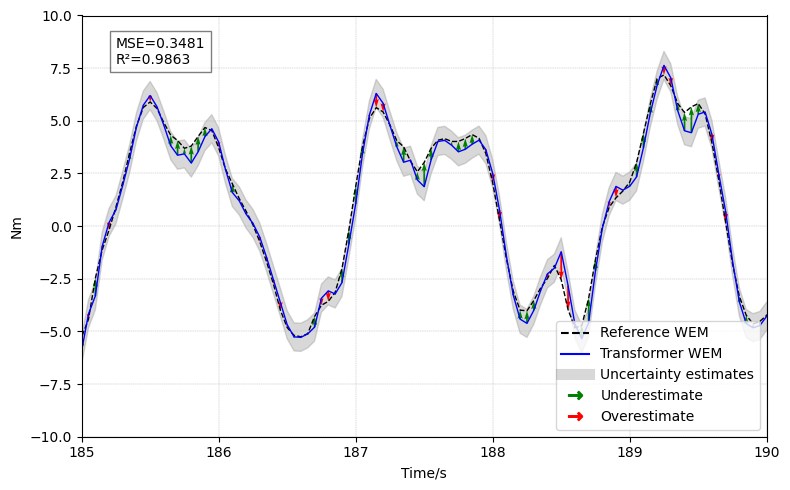

In [54]:
def plot_tf1(model, X_test, y_test, t_test):
    model.eval()
    with torch.no_grad():
        pred = model(X_test).squeeze(-1).numpy()
        true = y_test.numpy()

    # Compute residual standard deviation
    residuals = true - pred
    std = np.std(residuals)

    # 95% confidence bounds
    lower = pred - 1.96 * std
    upper = pred + 1.96 * std

    # Plot
    plt.figure(figsize=(8, 5))
    
    plt.plot(t_test, true, '--', c='black', label='Reference WEM', linewidth=1.0)
    plt.plot(t_test, pred, label='Transformer WEM', color='blue', linewidth=1.0)
    plt.fill_between(t_test, lower, upper, color='gray', 
                     alpha=0.3, label='Uncertainty estimates') #uncertainty region
    low = residuals > 0
    high = residuals <= 0

    plt.quiver(
        t_test[low], pred[low],
        [0]*np.sum(low), residuals[low],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='green', label='Underestimate'
    )
    plt.quiver(
        t_test[high], pred[high],
        [0]*np.sum(high), residuals[high],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='red', label='Overestimate'
    )
    
    
    plt.text(0.05, 0.95, 
             f'MSE={np.sqrt(mean_squared_error(true, pred)):.4f}\nR²={r2_score(true, pred):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
             bbox=dict(facecolor='white', alpha=0.5))
    plt.xlabel('Time/s')
    # plt.xlim(left=min(t_test), right=max(t_test))
    plt.xlim(185, 190)
    plt.ylim(bottom=-10, top=10)
    plt.ylabel('Nm')
    # plt.legend(loc='lower right', fontsize=10)
    legends = [
        Line2D([0], [0], linestyle='--', color='black', label='Reference WEM'),
        Line2D([0], [0], color='blue', label='Transformer WEM'),
        Line2D([0], [0], color='gray', lw=8, alpha=0.3, label='Uncertainty estimates'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='green', lw=0, markersize=10, label='Underestimate'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='red', lw=0, markersize=10, label='Overestimate'),
    ]
    plt.legend(handles=legends, loc='lower right', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()
plot_tf1(model11, X_test7, y_test7, t_test7)

#### 5b. Transformer (Ref Velocity)

In [55]:
X_train8, y_train8, X_test8, y_test8, t_train8, t_test8 = preprocess_vel(wem, theta_ref, time, n_lags=n_lags)

In [56]:
set_seed(42)
model12 = train_former(X_train8, y_train8, n_epochs=10)

Epoch 1/10, Loss: 0.0421
Epoch 2/10, Loss: 0.0201
Epoch 3/10, Loss: 0.0174
Epoch 4/10, Loss: 0.0144
Epoch 5/10, Loss: 0.0140
Epoch 6/10, Loss: 0.0129
Epoch 7/10, Loss: 0.0134
Epoch 8/10, Loss: 0.0132
Epoch 9/10, Loss: 0.0112
Epoch 10/10, Loss: 0.0108


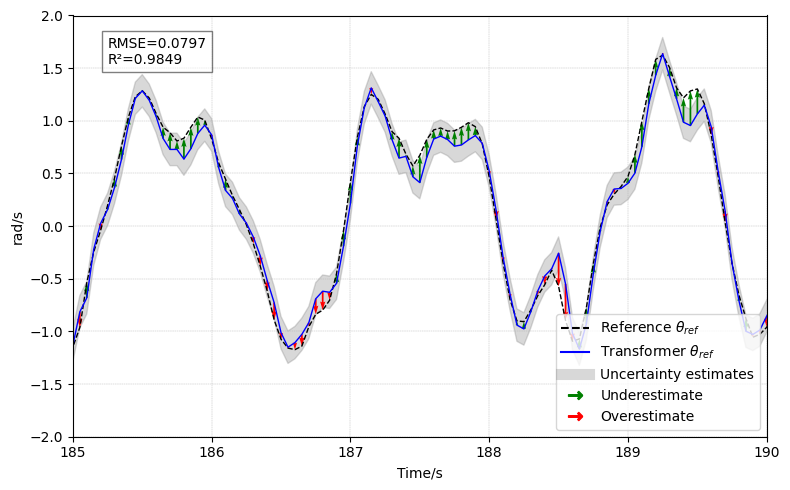

In [57]:
def plot_tf2(model, X_test, y_test, t_test):
    model.eval()
    with torch.no_grad():
        pred = model(X_test).squeeze(-1).numpy()
        true = y_test.numpy()

    # Compute residual standard deviation
    residuals = true - pred
    std = np.std(residuals)

    # 95% confidence bounds
    lower = pred - 1.96 * std
    upper = pred + 1.96 * std

    # Plot
    plt.figure(figsize=(8, 5))
    
    plt.plot(t_test, true, '--', c='black', label='Reference $θ̇_{ref}$', linewidth=1.0)
    plt.plot(t_test, pred, label='Transfomer $θ̇_{ref}$', color='blue', linewidth=1.0)
    plt.fill_between(t_test, lower, upper, color='gray', 
                     alpha=0.3, label='Uncertainty estimates') #uncertainty region
    low = residuals > 0
    high = residuals <= 0

    plt.quiver(
        t_test[low], pred[low],
        [0]*np.sum(low), residuals[low],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='green', label='Underestimate'
    )
    plt.quiver(
        t_test[high], pred[high],
        [0]*np.sum(high), residuals[high],
        angles='xy', scale_units='xy', scale=1,
        width=0.0025, color='red', label='Overestimate'
    )
    
    plt.text(0.05, 0.95, 
             f'RMSE={np.sqrt(mean_squared_error(true, pred)):.4f}\nR²={r2_score(true, pred):.4f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
             bbox=dict(facecolor='white', alpha=0.5))
    plt.xlabel('Time/s')
    # plt.xlim(left=min(t_test), right=max(t_test))
    plt.xlim(185, 190)
    plt.ylim(bottom=-2, top=2)
    plt.ylabel('rad/s')
    # plt.legend(loc='lower right', fontsize=10)
    legends = [
        Line2D([0], [0], linestyle='--', color='black', label='Reference $θ̇_{ref}$'),
        Line2D([0], [0], color='blue', label='Transformer $θ̇_{ref}$'),
        Line2D([0], [0], color='gray', lw=8, alpha=0.3, label='Uncertainty estimates'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='green', lw=0, markersize=10, label='Underestimate'),
        Line2D([0], [0], marker=r'$\rightarrow$', color='red', lw=0, markersize=10, label='Overestimate'),
    ]
    plt.legend(handles=legends, loc='lower right', fontsize=10)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()
plot_tf2(model12, X_test8, y_test8, t_test8)

In [ ]:
# Discrete-time state-space model
Ad = np.array([
    [0.9248,  0.0470, -0.0031,  0.0003],
    [-2.9282, 0.8480, -0.1066,  0.0254],
    [-0.4740, 0.2578,  0.4037, -0.4609],
    [-0.0681, 0.0608,  0.2747,  0.8947]
])

Bd = np.array([
    [0.00081],
    [0.03171],
    [0.00513],
    [0.00074]
])

Bd_mex = np.array([
    [0.0],
    [0.0],
    [0.1],
    [0.0]
])

Cv = np.array([[0, 1, 0, 0]])  # Measures angular velocity

# MPC hyperparameters
Np = 60
Qm = 0.5
Rm = 2e-4
u_max = 12.0


| Variable | Name                  | Description                                                                                                                                     |
| -------- | --------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| `Np`     | Prediction Horizon    | Number of steps the MPC predicts/control horizon into the future (e.g., 60 time steps).                                                         |
| `Qm`     | Tracking Cost Weight  | Penalizes the tracking error between predicted velocity and reference velocity (θ̇\_ref). A higher value means tracking becomes more important. |
| `Rm`     | Control Effort Weight | Penalizes the magnitude of control input (PTO torque). This helps avoid aggressive control actions.                                             |
| `u_max`  | Control Input Limit   | Maximum absolute value of the control input (PTO torque), enforcing physical actuator limits (±12 Nm).                                          |
| `Ad`     | Discrete-time State Matrix          | Represents the system dynamics (4×4 matrix), discretized from the continuous-time model of the WEC. Each row corresponds to the dynamics of states like position, velocity, or radiation force terms. |
| `Bd`     | Discrete-time Control Input Matrix  | Represents how the **control input** (e.g., Power Take-Off torque) affects the states.                                                                                                                |
| `Bd_mex` | Wave Excitation Moment Input Matrix | Maps the **wave excitation moment** (external forcing) to the states. This term accounts for wave forcing influence on dynamics.                                                                      |
| `Cv`     | Output Matrix                       | Maps the full state vector to the **measured output**, which in this case is the **angular velocity θ̇**. It picks the second state (velocity) from the full state vector.                            |


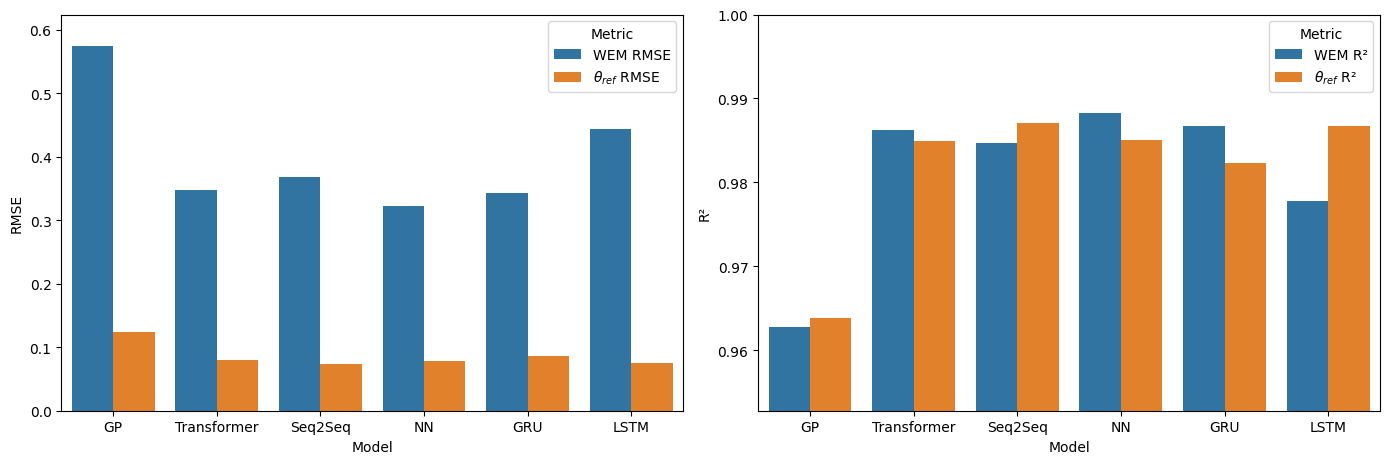

In [2]:
# Re-import needed libraries after code execution state reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create data from the image content
data = {
    "Model": ["GP", "Transformer", "Seq2Seq", "NN", "GRU", "LSTM"],
    "WEM_RMSE": [0.5737, 0.3481, 0.3672, 0.3223, 0.3424, 0.4431],
    "WEM_R2": [0.9628, 0.9863, 0.9847, 0.9883, 0.9867, 0.9778],
    "Theta_RMSE": [0.1236, 0.0797, 0.0737, 0.0780, 0.0863, 0.0748],
    "Theta_R2": [0.9638, 0.9849, 0.9871, 0.9850, 0.9823, 0.9867],
}

df = pd.DataFrame(data)

# Melt for plotting
df_melted = df.melt(id_vars="Model", var_name="Metric", value_name="Score")

# Split RMSE and R2 for separate plots
rmse_df = df_melted[df_melted["Metric"].str.contains("RMSE")]
r2_df = df_melted[df_melted["Metric"].str.contains("R2")]

# define better names for metrics
label_map = {
    "WEM_RMSE": "WEM RMSE",
    "Theta_RMSE": "$θ̇_{ref}$ RMSE",
    "WEM_R2": "WEM R²",
    "Theta_R2": "$θ̇_{ref}$ R²"
}

# Replace the Metric labels with human-readable ones
rmse_df_labeled = rmse_df.copy()
r2_df_labeled = r2_df.copy()

rmse_df_labeled["Metric"] = rmse_df_labeled["Metric"].replace(label_map)
r2_df_labeled["Metric"] = r2_df_labeled["Metric"].replace(label_map)

# Plot with subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# RMSE subplot
sns.barplot(ax=ax[0], x="Model", y="Score", hue="Metric", data=rmse_df_labeled)
# ax[0].set_title("RMSE Comparison")
ax[0].set_ylabel("RMSE")
ax[0].set_ylim(0, max(rmse_df_labeled["Score"]) + 0.05)
ax[0].legend(title="Metric", loc="upper right")

# R² subplot
sns.barplot(ax=ax[1], x="Model", y="Score", hue="Metric", data=r2_df_labeled)
# ax[1].set_title("R² Score Comparison")
ax[1].set_ylabel("R²")
ax[1].set_ylim(min(r2_df_labeled["Score"]) - 0.01, 1)
ax[1].legend(title="Metric", loc="upper right")

# plt.suptitle("Comparative Performance of Models on WEM and $\\thetȧ_{ref}$ Prediction", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
